In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [118]:
df = pd.read_excel('C:/Users/user/OneDrive/Рабочий стол/Доп учеба/Хакатоны/ЦП 3 дашборд/train_dataset_rzhd_rating_train/dataset.xlsx')

In [3]:
def calculate_coefficient1(temp): # Кэф путевого отклонения
    if temp == 0:
        return 1
    elif temp >= 0.2:
        return 0.6
    elif temp >= 0.1:
        return 0.7
    else:
        return 0.8

In [4]:
def calculate_coefficient2(temp): # Кэф соответствия целевой структуре
    if temp == 0:
        return 1
    elif temp >= 0.2:
        return 0.6
    elif temp >= 0.1:
        return 0.7
    else:
        return 0.8

In [5]:
def calculate_coefficient3(temp): # Кэф манера вождения
    temp = 1 - temp/6 
    if temp == 0:
        return 1
    elif temp >= 0.2:
        return 0.7
    elif temp >= 0.15:
        return 0.8
    else:
        return 0.9

In [6]:
def calculate_coefficient4(temp, max_val):
    temp = temp/max_val
    if temp >= 0.2:
        return 0.7
    elif temp >= 0.15:
        return 0.8
    else:
        return 0.9

In [58]:
def assign_coefficient(value):
    if value == 0:
        return 1
    elif 1 <= value <= 5:
        return 0.8
    elif 6 <= value <= 12:
        return 0.7
    else:
        return 0.6

In [20]:
def add_rolling_mean_features(df, window_size):
    df = df.sort_values(by=['Наименование структурного подразделения', 'Дата'])
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    for col in numeric_cols:
        df[f'{col}_rolling_mean'] = df.groupby('Наименование полигона')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    return df

In [144]:
def preprocessing(df, range_pred):
    # удаляем ненужное
    df = df.dropna(how='all')
    df = df.drop(['Выполняемые функции', 'Должность за кем закреплен ТС'], axis=1)
    # Заполняем пропуски
    df['Наименование полигона'] = df['Наименование полигона'].fillna(method='ffill')
    df['Краткое наименование'] = df['Краткое наименование'].fillna(method='ffill')
    df['Полигон'] = df['Полигон'].fillna(method='ffill')
    df['Номерной знак ТС'] = df['Номерной знак ТС'].fillna(method='ffill')
    df['Тип закрепления'] = df['Тип закрепления'].fillna(method='ffill')
    df['Наименование структурного подразделения'] = df['Наименование структурного подразделения'].fillna(method='ffill')
    df['манера вождения'] = df['манера вождения'].fillna(method='ffill')
    df['Штрафы'] = df['Штрафы'].fillna(0)
    # Делаем нужный формат времени
    df['дата путевого листа'] = pd.to_datetime(df['дата путевого листа'], format='%Y-%m-%d')
    df['Дата сигнала телематики'] = pd.to_datetime(df['Дата сигнала телематики'], format='%Y-%m-%d')
    # Делаем провильное расположение дат
    agg_cols1 = ['Наименование полигона', 'Краткое наименование', 'Полигон', 'Номерной знак ТС', 'Наименование структурного подразделения', 'Тип закрепления']
    grouped = df.groupby(agg_cols1)
    new_dfs = []
    for _, data in grouped:
        temp1_df = data.drop(columns=['Дата сигнала телематики', 'Данные телематики, пробег','Штрафы', 'манера вождения']).rename(columns={'дата путевого листа': 'Дата'})
        pd.DataFrame({'Дата': data['дата путевого листа'], 'Данные путевых листов, пробег': data['Данные путевых листов, пробег']})
        temp2_df = data.drop(columns=['дата путевого листа', 'Данные путевых листов, пробег']).rename(columns={'Дата сигнала телематики': 'Дата'})
        new_df = pd.merge(temp1_df, temp2_df,how='outer',on=['Дата']+agg_cols1 ).sort_values(by='Дата')
        new_df = new_df.dropna(subset='Дата')
        new_dfs.append(new_df)
    df = pd.concat(new_dfs).reset_index(drop=True)
    # Новые признаки
    df['Поездка не по плану'] = df.apply(lambda row: 1 if pd.isna(row['Данные путевых листов, пробег']) and not pd.isna(row['Данные телематики, пробег']) else 0, axis=1)
    df['Не выполнил поездку'] = df.apply(lambda row: 1 if not pd.isna(row['Данные путевых листов, пробег']) and pd.isna(row['Данные телематики, пробег']) else 0, axis=1)
    # df['Разница план_реальность(дни)'] = df.apply(lambda row: (row['дата путевого листа'] - row['Дата сигнала телематики']).days if not pd.isna(row['дата путевого листа']) and not pd.isna(row['Дата сигнала телематики']) else None, axis=1)
    # df['Разница план_реальность(дни)'] = df['Разница план_реальность(дни)'].fillna(0)
    # Удаляем строки, которые дают информацию суммарную(мы сами будем агригировать)
    columns_to_check = [
    "Наименование полигона", "Краткое наименование", "Полигон", 
    "Номерной знак ТС", "Наименование структурного подразделения", "Тип закрепления"
    ]
    df = df.reset_index(drop=True)

    def remove_changed_rows(df, columns):
        indices_to_remove = []
        previous_row = df.iloc[0][columns]

        for i in range(0, len(df)):
            current_row = df.iloc[i][columns]
            if not current_row.equals(previous_row):
                indices_to_remove.append(i)
                previous_row = current_row

        df_removed = df.iloc[indices_to_remove]
        df_cleaned = df.drop(indices_to_remove) # для проверки
        return df_cleaned, df_removed

    df_cleaned, df_removed = remove_changed_rows(df, columns_to_check)
    df = df_cleaned
    df = df.reset_index(drop=True)
    # One_hot для типа закрепления
    one_hot_encoder = OneHotEncoder()
    one_hot_encoded = one_hot_encoder.fit_transform(df[['Тип закрепления']])
    df_one_hot = pd.DataFrame(one_hot_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(['Тип закрепления']))
    df = pd.concat([df.drop('Тип закрепления', axis=1), df_one_hot], axis=1)
    # Агрегация
    aggregations = {
    'Данные путевых листов, пробег': 'sum',
    'Данные телематики, пробег': 'sum',
    'Штрафы': 'sum',
    'Тип закрепления_В целевой структуре парка': 'sum',
    'Тип закрепления_Прочие': 'sum',
    'манера вождения': 'mean',
    # 'Разница план_реальность(дни)': 'mean',
    'Поездка не по плану': 'max',
    'Не выполнил поездку': 'mean'#,
    # 'Кэф путевого отклонения': 'mean'
    }
    agg_cols = ['Наименование полигона', 'Краткое наименование', 'Полигон', 'Наименование структурного подразделения', 'Дата']
    agg_df = df.groupby(agg_cols).agg(aggregations).reset_index()
    agg_df['количество записей'] = df.groupby(agg_cols).size().reset_index(name='количество записей')['количество записей']
    # расчет коэффициента 1
    agg_df['temp'] = abs(agg_df['Данные путевых листов, пробег'] - agg_df['Данные телематики, пробег']) / agg_df['Данные путевых листов, пробег']
    agg_df['Кэф путевого отклонения'] = agg_df['temp'].apply(lambda x: calculate_coefficient1(x))
    agg_df.drop(columns=['temp'], inplace=True)
    # расчет коэффициента 2
    agg_df['temp'] = abs(agg_df['Тип закрепления_В целевой структуре парка'] - agg_df['количество записей']) / agg_df['Тип закрепления_В целевой структуре парка']
    agg_df['Кэф соответствия целевой структуре'] = agg_df['temp'].apply(lambda x: calculate_coefficient2(x))
    agg_df.drop(columns=['temp'], inplace=True)
    # расчет коэффициента 3
    agg_df['Кэф манера вождения'] = df['манера вождения'].apply(lambda x: calculate_coefficient3(x))
    # agg_df.drop(columns=['манера вождения'], inplace=True)
    # расчет коэффициента 4
    # max_val = max(agg_df['Штрафы'])
    # agg_df['Кэф Штрафы'] = agg_df['Штрафы'].apply(lambda x: calculate_coefficient4(x, max_val))
    # print(agg_df['Штрафы'].value_counts())
    agg_df['Кэф Штрафы'] = agg_df['Штрафы'].apply(assign_coefficient)
    # agg_df['Кэф Штрафы'] = pd.qcut(agg_df['Штрафы'], q=[0, 0.9, 0.95, 1.0], labels=[0.9, 0.8], duplicates='drop').astype('int')
    # agg_df.drop(columns=['манера вождения'], inplace=True)
    # Подсчет оценки 
    agg_df['grade'] = 0.4*agg_df['Кэф путевого отклонения'] + 0.3*agg_df['Кэф соответствия целевой структуре'] + 0.15*agg_df['Кэф Штрафы'] + 0.15*agg_df['Кэф манера вождения']
    # Скользящее окно
    window_size = range_pred
    df_rolling_vals = add_rolling_mean_features(agg_df, window_size)
    # поменяем дату для модели
    # df_rolling_vals['День недели'] = df_rolling_vals['дата путевого листа'].dt.day_name()
    # df_rolling_vals['Дата'] = df_rolling_vals['дата путевого листа'].dt.day
    # df_rolling_vals = df_rolling_vals.drop(columns=['дата путевого листа'])
    return df_rolling_vals

In [145]:
from sklearn.preprocessing import MinMaxScaler
def get_new_rating(df):
    # df['манера вождения'] = df['манера вождения'].fillna(method='ffill')
    df['путевое отколение temp'] = 1 - abs(df['Данные путевых листов, пробег'] - df['Данные телематики, пробег'])
    df['соответствие целевой структуре temp'] = 1 - abs(df['Тип закрепления_В целевой структуре парка'] - df['количество записей'])
    df['Штраф temp'] = 1 - df['Штрафы']
    df['манера вождения temp'] = df['манера вождения']

    columns_to_scale = ['путевое отколение temp', 'соответствие целевой структуре temp', 'Штраф temp', 'манера вождения temp']
    scaler = MinMaxScaler()
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    df['Rating 2.0'] = 0.4*df['путевое отколение temp'] + 0.3*df['соответствие целевой структуре temp'] + 0.15*df['Штраф temp'] + 0.15*df['манера вождения temp']
    df.drop(columns=columns_to_scale, inplace=True)
    return df

In [146]:
df_rolling_vals = preprocessing(df, 7)
print(df_rolling_vals.shape)
# df_rolling_vals = get_new_rating(df_rolling_vals)
# print(df_rolling_vals.shape)

(348, 33)


In [147]:
df_rolling_vals

,Наименование полигона,Краткое наименование,Полигон,Наименование структурного подразделения,Дата,"Данные путевых листов, пробег","Данные телематики, пробег",Штрафы,Тип закрепления_В целевой структуре парка,Тип закрепления_Прочие,манера вождения,Поездка не по плану,Не выполнил поездку,количество записей,Кэф путевого отклонения,Кэф соответствия целевой структуре,Кэф манера вождения,Кэф Штрафы,grade,"Данные путевых листов, пробег_rolling_mean","Данные телематики, пробег_rolling_mean",Штрафы_rolling_mean,Тип закрепления_В целевой структуре парка_rolling_mean,Тип закрепления_Прочие_rolling_mean,манера вождения_rolling_mean,Поездка не по плану_rolling_mean,Не выполнил поездку_rolling_mean,количество записей_rolling_mean,Кэф путевого отклонения_rolling_mean,Кэф соответствия целевой структуре_rolling_mean,Кэф манера вождения_rolling_mean,Кэф Штрафы_rolling_mean,grade_rolling_mean
290,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-02,5393.00,5169.00,0.0,16.0,0.0,5.358333,1,0.250000,16,0.8,1.0,0.9,1.0,0.905,5393.000000,5169.000000,0.000000,16.000000,0.000000,5.358333,1.00,0.250000,16.000000,0.800000,1.000000,0.900000,1.000000,0.905000
291,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-03,4781.00,5412.76,0.0,15.0,0.0,5.175000,1,0.200000,15,0.7,1.0,0.9,1.0,0.865,5087.000000,5290.880000,0.000000,15.500000,0.000000,5.266667,1.00,0.225000,15.500000,0.750000,1.000000,0.900000,1.000000,0.885000
292,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-04,4130.00,3706.00,0.0,14.0,0.0,5.511111,1,0.357143,14,0.7,1.0,0.9,1.0,0.865,4768.000000,4762.586667,0.000000,15.000000,0.000000,5.348148,1.00,0.269048,15.000000,0.733333,1.000000,0.900000,1.000000,0.878333
293,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-05,4325.00,3142.00,0.0,14.0,0.0,5.477778,0,0.357143,14,0.6,1.0,1.0,1.0,0.840,4657.250000,4357.440000,0.000000,14.750000,0.000000,5.380556,0.75,0.291071,14.750000,0.700000,1.000000,0.925000,1.000000,0.868750
294,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-06,4769.00,3346.00,0.0,16.0,0.0,5.688889,1,0.437500,16,0.6,1.0,1.0,1.0,0.840,4679.600000,4155.152000,0.000000,15.000000,0.000000,5.442222,0.80,0.320357,15.000000,0.680000,1.000000,0.940000,1.000000,0.863000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,МОСКОВСКАЯ ЖД,ЦМ,Московская ДМ,Орловская механизированная дистанция погрузочн...,2024-04-26,1206.00,2264.26,7.0,10.0,0.0,5.387500,1,0.200000,10,0.6,1.0,0.9,0.7,0.780,703.142857,1100.440000,4.142857,10.285714,0.000000,5.340476,1.00,0.263389,10.285714,0.614286,1.000000,0.900000,0.800000,0.800714
226,МОСКОВСКАЯ ЖД,ЦМ,Московская ДМ,Орловская механизированная дистанция погрузочн...,2024-04-27,432.00,600.00,3.0,10.0,0.0,5.357143,1,0.300000,10,0.6,1.0,0.9,0.8,0.795,708.285714,1075.725714,4.000000,10.142857,0.000000,5.343878,1.00,0.280272,10.142857,0.614286,1.000000,0.900000,0.800000,0.800714
227,МОСКОВСКАЯ ЖД,ЦМ,Московская ДМ,Орловская механизированная дистанция погрузочн...,2024-04-28,1014.00,1657.45,1.0,11.0,1.0,4.490000,1,0.166667,12,0.6,0.8,0.9,0.8,0.735,727.142857,1146.495714,3.571429,10.857143,0.142857,5.278163,1.00,0.256463,11.000000,0.614286,0.971429,0.900000,0.800000,0.792143
228,МОСКОВСКАЯ ЖД,ЦМ,Московская ДМ,Орловская механизированная дистанция погрузочн...,2024-04-29,176.11,650.32,4.0,12.0,0.0,5.128571,1,0.416667,12,0.6,1.0,0.9,0.8,0.795,722.015714,1148.002857,4.142857,11.285714,0.142857,5.225102,1.00,0.268367,11.428571,0.614286,0.971429,0.900000,0.771429,0.787857


In [127]:
pd.set_option('display.max_columns', 500)
df_rolling_vals

,Наименование полигона,Краткое наименование,Полигон,Наименование структурного подразделения,Дата,"Данные путевых листов, пробег","Данные телематики, пробег",Штрафы,Тип закрепления_В целевой структуре парка,Тип закрепления_Прочие,манера вождения,Поездка не по плану,Не выполнил поездку,количество записей,Кэф путевого отклонения,Кэф соответствия целевой структуре,Кэф манера вождения,Кэф Штрафы,grade,"Данные путевых листов, пробег_rolling_mean","Данные телематики, пробег_rolling_mean",Штрафы_rolling_mean,Тип закрепления_В целевой структуре парка_rolling_mean,Тип закрепления_Прочие_rolling_mean,манера вождения_rolling_mean,Поездка не по плану_rolling_mean,Не выполнил поездку_rolling_mean,количество записей_rolling_mean,Кэф путевого отклонения_rolling_mean,Кэф соответствия целевой структуре_rolling_mean,Кэф манера вождения_rolling_mean,Кэф Штрафы_rolling_mean,grade_rolling_mean,Rating 2.0
290,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-02,5393.00,5169.00,0.0,16.0,0.0,5.358333,1,0.250000,16,0.8,1.0,0.9,1.0,0.905,5393.000000,5169.000000,0.000000,16.000000,0.000000,5.358333,1.00,0.250000,16.000000,0.800000,1.000000,0.900000,1.000000,0.905000,0.960729
291,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-03,4781.00,5412.76,0.0,15.0,0.0,5.175000,1,0.200000,15,0.7,1.0,0.9,1.0,0.865,5087.000000,5290.880000,0.000000,15.500000,0.000000,5.266667,1.00,0.225000,15.500000,0.750000,1.000000,0.900000,1.000000,0.885000,0.922812
292,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-04,4130.00,3706.00,0.0,14.0,0.0,5.511111,1,0.357143,14,0.7,1.0,0.9,1.0,0.865,4768.000000,4762.586667,0.000000,15.000000,0.000000,5.348148,1.00,0.269048,15.000000,0.733333,1.000000,0.900000,1.000000,0.878333,0.950405
293,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-05,4325.00,3142.00,0.0,14.0,0.0,5.477778,0,0.357143,14,0.6,1.0,1.0,1.0,0.840,4657.250000,4357.440000,0.000000,14.750000,0.000000,5.380556,0.75,0.291071,14.750000,0.700000,1.000000,0.925000,1.000000,0.868750,0.890325
294,СЕВЕРНАЯ ЖД,ЦМ,Северная ДМ,Архангельская механизированная дистанция ПРР и КО,2024-04-06,4769.00,3346.00,0.0,16.0,0.0,5.688889,1,0.437500,16,0.6,1.0,1.0,1.0,0.840,4679.600000,4155.152000,0.000000,15.000000,0.000000,5.442222,0.80,0.320357,15.000000,0.680000,1.000000,0.940000,1.000000,0.863000,0.878883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,МОСКОВСКАЯ ЖД,ЦМ,Московская ДМ,Орловская механизированная дистанция погрузочн...,2024-04-26,1206.00,2264.26,7.0,10.0,0.0,5.387500,1,0.200000,10,0.6,1.0,0.9,0.7,0.780,703.142857,1100.440000,4.142857,10.285714,0.000000,5.340476,1.00,0.263389,10.285714,0.614286,1.000000,0.900000,0.800000,0.800714,0.869303
226,МОСКОВСКАЯ ЖД,ЦМ,Московская ДМ,Орловская механизированная дистанция погрузочн...,2024-04-27,432.00,600.00,3.0,10.0,0.0,5.357143,1,0.300000,10,0.6,1.0,0.9,0.8,0.795,708.285714,1075.725714,4.000000,10.142857,0.000000,5.343878,1.00,0.280272,10.142857,0.614286,1.000000,0.900000,0.800000,0.800714,0.953195
227,МОСКОВСКАЯ ЖД,ЦМ,Московская ДМ,Орловская механизированная дистанция погрузочн...,2024-04-28,1014.00,1657.45,1.0,11.0,1.0,4.490000,1,0.166667,12,0.6,0.8,0.9,0.8,0.735,727.142857,1146.495714,3.571429,10.857143,0.142857,5.278163,1.00,0.256463,11.000000,0.614286,0.971429,0.900000,0.800000,0.792143,0.857105
228,МОСКОВСКАЯ ЖД,ЦМ,Московская ДМ,Орловская механизированная дистанция погрузочн...,2024-04-29,176.11,650.32,4.0,12.0,0.0,5.128571,1,0.416667,12,0.6,1.0,0.9,0.8,0.795,722.015714,1148.002857,4.142857,11.285714,0.142857,5.225102,1.00,0.268367,11.428571,0.614286,0.971429,0.900000,0.771429,0.787857,0.917675


<Axes: >

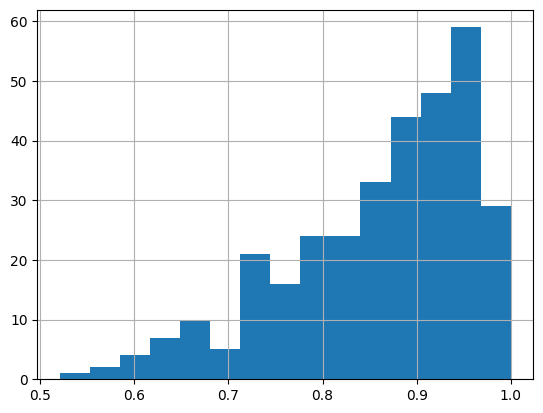

In [131]:
df_rolling_vals['Rating 2.0'].hist(bins=15)

In [78]:
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error, r2_score

df_rolling_vals['grade'] = df_rolling_vals.groupby('Наименование полигона')['grade'].shift(-7)
df_rolling_vals = df_rolling_vals.dropna(subset=['grade'])
df_rolling_vals = df_rolling_vals.sort_values(by='Дата')

train_size = int(len(df_rolling_vals) * 0.8)
train_df = df_rolling_vals.iloc[:train_size]
test_df = df_rolling_vals.iloc[train_size:]

X_train = train_df.drop(columns=['grade', 'Наименование полигона',	'Краткое наименование',	'Полигон',	'Наименование структурного подразделения'])
y_train = train_df['grade']
X_test = test_df.drop(columns=['grade', 'Наименование полигона',	'Краткое наименование',	'Полигон',	'Наименование структурного подразделения'])
y_test = test_df['grade']
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

params = {
    'iterations': 100,
    'depth': 5,
    'learning_rate': 0.1,
    'loss_function': 'RMSE',
    'eval_metric': 'R2',
    'random_seed': 42
}

train_pool = Pool(data=X_train, label=y_train,  cat_features=cat_features)

# Использование кросс-валидации
# cv_results = cv(train_pool, params, fold_count=4, plot=True)

# Обучение модели на всех обучающих данных
model = CatBoostRegressor(**params)
model.fit(X_train, y_train)

# Предсказания и оценка на тестовой выборке
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) на тестовой выборке: {:.2f}".format(mse))
print("R-squared (R²) на тестовой выборке: {:.2f}".format(r2))


0:	learn: 0.0620073	total: 4.09ms	remaining: 405ms
1:	learn: 0.1164288	total: 5.84ms	remaining: 286ms
2:	learn: 0.1723165	total: 7.38ms	remaining: 239ms
3:	learn: 0.2328719	total: 9.24ms	remaining: 222ms
4:	learn: 0.2766395	total: 21ms	remaining: 398ms
5:	learn: 0.3181900	total: 22.1ms	remaining: 347ms
6:	learn: 0.3543758	total: 25.4ms	remaining: 337ms
7:	learn: 0.3861585	total: 28.6ms	remaining: 328ms
8:	learn: 0.4193288	total: 30.3ms	remaining: 307ms
9:	learn: 0.4512619	total: 32.3ms	remaining: 291ms
10:	learn: 0.4769342	total: 35.6ms	remaining: 288ms
11:	learn: 0.5005237	total: 37.6ms	remaining: 276ms
12:	learn: 0.5317410	total: 38.8ms	remaining: 260ms
13:	learn: 0.5540948	total: 40.3ms	remaining: 248ms
14:	learn: 0.5720819	total: 41.1ms	remaining: 233ms
15:	learn: 0.5926550	total: 41.9ms	remaining: 220ms
16:	learn: 0.6113716	total: 46.3ms	remaining: 226ms
17:	learn: 0.6218377	total: 48ms	remaining: 219ms
18:	learn: 0.6379770	total: 49.9ms	remaining: 213ms
19:	learn: 0.6544893	total

In [98]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df_rolling_vals['grade'] = df_rolling_vals.groupby('Наименование полигона')['grade'].shift(-7)
df_rolling_vals = df_rolling_vals.dropna(subset=['grade'])
df_rolling_vals = df_rolling_vals.sort_values(by='Дата')

train_size = int(len(df_rolling_vals) * 0.8)
train_df = df_rolling_vals.iloc[:train_size]
test_df = df_rolling_vals.iloc[train_size:]

X_train = train_df.drop(columns=['grade', 'Наименование полигона',	'Краткое наименование',	'Полигон',	'Наименование структурного подразделения'])
y_train = train_df['grade']
X_test = test_df.drop(columns=['grade', 'Наименование полигона',	'Краткое наименование',	'Полигон',	'Наименование структурного подразделения'])
y_test = test_df['grade']
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

model = CatBoostRegressor(iterations=1000, learning_rate=0.004, depth=4, eval_metric='RMSE', random_seed=42)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
# validation_pool = Pool(X_val, y_val, cat_features=cat_features)
model.fit(train_pool, verbose=500, plot=True)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE на тесте: {mse}")
print(f"R2 на тесте: {r2}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0771754	total: 876us	remaining: 876ms
500:	learn: 0.0523244	total: 429ms	remaining: 427ms
999:	learn: 0.0384273	total: 699ms	remaining: 0us
MSE на тесте: 0.003969430926653636
R2 на тесте: 0.18862876454522348


Lag: 2, Mean R2: 0.2902376086112718, Mean MSE: 0.007289243654350523, Mean MAE: 0.06287803368065079, Mean WAPE: 0.07953816390934355, Mean MAPE: 7.953816390934355
Lag: 3, Mean R2: 0.2639488443837562, Mean MSE: 0.0075123376749007004, Mean MAE: 0.06344652204243191, Mean WAPE: 0.08042985201643549, Mean MAPE: 8.04298520164355
Lag: 4, Mean R2: 0.2136260154981898, Mean MSE: 0.007881274072216398, Mean MAE: 0.06634505491612666, Mean WAPE: 0.08398406198498136, Mean MAPE: 8.398406198498137
Lag: 5, Mean R2: 0.17930827686239964, Mean MSE: 0.007587692943412118, Mean MAE: 0.06364641593080866, Mean WAPE: 0.07854949587968686, Mean MAPE: 7.8549495879686875
Lag: 6, Mean R2: 0.152002510605872, Mean MSE: 0.007866420419286674, Mean MAE: 0.06523282911299742, Mean WAPE: 0.08014507862544154, Mean MAPE: 8.014507862544155
Lag: 7, Mean R2: 0.05614513185623053, Mean MSE: 0.008129163278544122, Mean MAE: 0.06607078681786518, Mean WAPE: 0.07886012350789129, Mean MAPE: 7.886012350789128
Lag: 8, Mean R2: 0.1568677624873

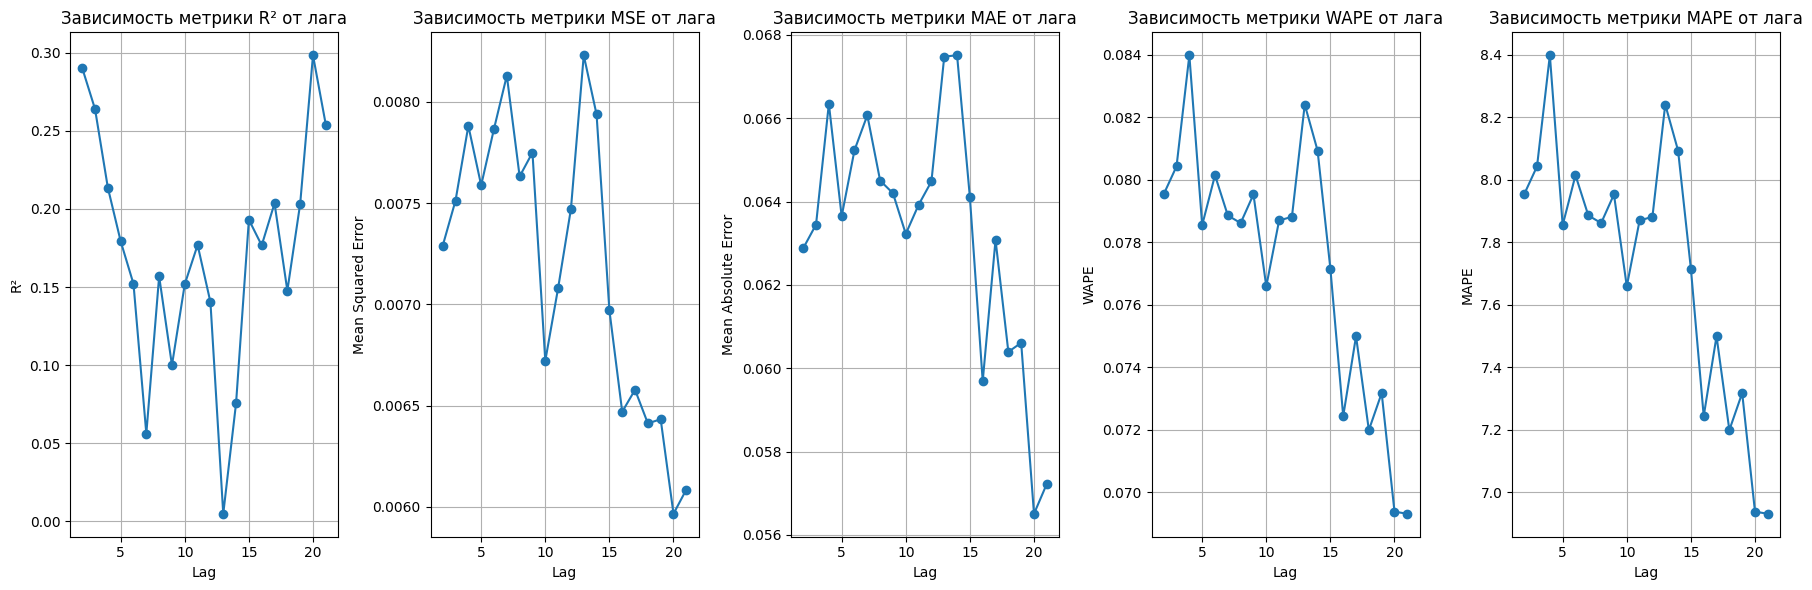

([0.2902376086112718,
  0.2639488443837562,
  0.2136260154981898,
  0.17930827686239964,
  0.152002510605872,
  0.05614513185623053,
  0.1568677624873816,
  0.0999640799867468,
  0.1518659644050774,
  0.1769423357167438,
  0.14038020889001196,
  0.00485349017141361,
  0.075679356422096,
  0.19308432914449597,
  0.1767013357775538,
  0.20361794551946016,
  0.14769972623689404,
  0.20328688369560685,
  0.29837607004880007,
  0.2538698177601334],
 [0.007289243654350523,
  0.0075123376749007004,
  0.007881274072216398,
  0.007587692943412118,
  0.007866420419286674,
  0.008129163278544122,
  0.007631484727833542,
  0.007749331243351294,
  0.006721348273319263,
  0.007079827844785601,
  0.007470876622700647,
  0.00822967710067829,
  0.007937465592177294,
  0.006970958221901638,
  0.0064696698434575746,
  0.006578309983937894,
  0.006412327580219636,
  0.006432925788076438,
  0.005966102900047897,
  0.006085769320405492],
 [0.06287803368065079,
  0.06344652204243191,
  0.06634505491612666,
 

In [136]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def wape(y_true, y_pred, weights):
    abs_percentage_errors = np.abs((y_true - y_pred) / y_true)
    weighted_abs_percentage_errors = abs_percentage_errors * weights
    return np.mean(weighted_abs_percentage_errors)

def mape(y_true, y_pred):
    abs_percentage_errors = np.abs((y_true - y_pred) / y_true)
    return np.mean(abs_percentage_errors) * 100

def evaluate_lag_dependence(df, min_lag=2, max_lag=14):
    r2_scores = []
    mse_scores = []
    mae_scores = []
    wape_scores = []
    mape_scores = []
    
    for lag in range(min_lag, max_lag + 1,):
        df_rolling_vals = preprocessing(df, lag)
        df_rolling_vals = get_new_rating(df_rolling_vals)
        df_rolling_vals['Rating 2.0'] = df_rolling_vals.groupby('Наименование полигона')['Rating 2.0'].shift(-lag)
        df_rolling_vals = df_rolling_vals.dropna(subset=['Rating 2.0'])
        df_rolling_vals = df_rolling_vals.sort_values(by='Дата')
        
        # Разделение на признаки и целевую переменную
        X = df_rolling_vals.drop(columns=['grade', 'Наименование полигона', 'Краткое наименование', 'Полигон', 'Наименование структурного подразделения','Rating 2.0'])
        y = df_rolling_vals['Rating 2.0']
        cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

        tscv = TimeSeriesSplit(n_splits=5)
        fold_r2_scores = []
        fold_mse_scores = []
        fold_mae_scores = []
        fold_wape_scores = []
        fold_mape_scores = []

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = CatBoostRegressor(iterations=1000, learning_rate=0.004, depth=3, eval_metric='RMSE', random_seed=42)
            model.fit(X_train, y_train, cat_features=cat_features, verbose=False, plot=False)

            y_pred = model.predict(X_test)

            fold_r2_scores.append(r2_score(y_test, y_pred))
            fold_mse_scores.append(mean_squared_error(y_test, y_pred))
            fold_mae_scores.append(mean_absolute_error(y_test, y_pred))

            # Допустим, веса равны единице для каждого наблюдения
            weights = np.ones_like(y_test)
            fold_wape_scores.append(wape(y_test, y_pred, weights))
            fold_mape_scores.append(mape(y_test, y_pred))

        r2_scores.append(np.mean(fold_r2_scores))
        mse_scores.append(np.mean(fold_mse_scores))
        mae_scores.append(np.mean(fold_mae_scores))
        wape_scores.append(np.mean(fold_wape_scores))
        mape_scores.append(np.mean(fold_mape_scores))

        print(f"Lag: {lag}, Mean R2: {np.mean(fold_r2_scores)}, Mean MSE: {np.mean(fold_mse_scores)}, Mean MAE: {np.mean(fold_mae_scores)}, Mean WAPE: {np.mean(fold_wape_scores)}, Mean MAPE: {np.mean(fold_mape_scores)}")

    # Строим графики зависимости метрик от значения лага
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 5, 1)
    plt.plot(range(min_lag, max_lag + 1), r2_scores, marker='o')
    plt.xlabel("Lag")
    plt.ylabel("R²")
    plt.title("Зависимость метрики R² от лага")
    plt.grid(True)

    plt.subplot(1, 5, 2)
    plt.plot(range(min_lag, max_lag + 1), mse_scores, marker='o')
    plt.xlabel("Lag")
    plt.ylabel("Mean Squared Error")
    plt.title("Зависимость метрики MSE от лага")
    plt.grid(True)

    plt.subplot(1, 5, 3)
    plt.plot(range(min_lag, max_lag + 1), mae_scores, marker='o')
    plt.xlabel("Lag")
    plt.ylabel("Mean Absolute Error")
    plt.title("Зависимость метрики MAE от лага")
    plt.grid(True)

    plt.subplot(1, 5, 4)
    plt.plot(range(min_lag, max_lag + 1), wape_scores, marker='o')
    plt.xlabel("Lag")
    plt.ylabel("WAPE")
    plt.title("Зависимость метрики WAPE от лага")
    plt.grid(True)

    plt.subplot(1, 5, 5)
    plt.plot(range(min_lag, max_lag + 1), mape_scores, marker='o')
    plt.xlabel("Lag")
    plt.ylabel("MAPE")
    plt.title("Зависимость метрики MAPE от лага")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return r2_scores, mse_scores, mae_scores, wape_scores, mape_scores

# Пример вызова функции
# df - ваш исходный датафрейм
evaluate_lag_dependence(df, min_lag=2, max_lag=21)

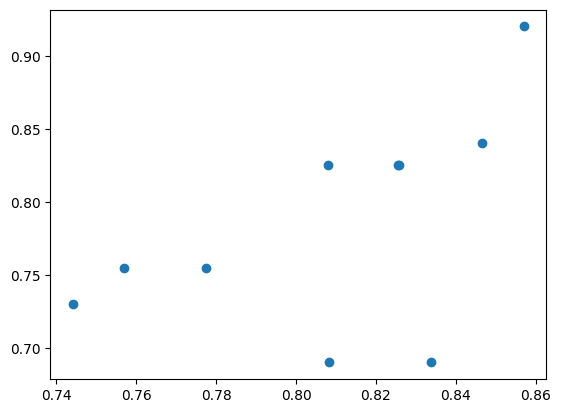

In [105]:
plt.scatter(y_pred, y_test)